# TRM VLM Inference

Load a saved TRM VLM checkpoint, fetch one PixMo-Cap example, display the image, and compute image/text cosine similarity.

In [1]:
# Setup: imports, paths, and model loading
import torch
from pathlib import Path
from torch.serialization import add_safe_globals
from transformers import AutoTokenizer
from trm_vlm_helper import TRMVLM, TRMVLMConfig, TRMDecoderConfig, TRMDecoderLLM

# Paths to the saved model (adjust if your checkpoint lives elsewhere)
MODEL_DIR = Path('artifacts/trm_vlm_model')
CKPT_PATH = MODEL_DIR / 'pytorch_model.bin'
CFG_PATH = MODEL_DIR / 'config.pt'
TOKENIZER_NAME = 'bert-base-uncased'

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
MODEL_DIR.resolve()

PosixPath('/storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/artifacts/trm_vlm_model')

In [3]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Allowlist config classes for torch.load safety
add_safe_globals([TRMVLMConfig, TRMDecoderConfig])

Using device: cuda


In [4]:
if not CFG_PATH.exists():
    raise FileNotFoundError(f"Config not found: {CFG_PATH}. Update MODEL_DIR.")

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
config = torch.load(CFG_PATH, map_location="cpu", weights_only=False)
if isinstance(config, dict):
    if "vision_embed_dim" in config:
        config = TRMVLMConfig(**config)
    else:
        config = TRMDecoderConfig(**config)
config

TRMVLMConfig(img_size=64, patch_size=8, vision_embed_dim=128, vision_num_heads=4, vision_num_layers=2, vision_n_recursions=3, vocab_size=1000, lang_hidden_size=128, lang_num_heads=4, lang_num_layers=2, max_seq_len=64, lang_n_recursions=3, lang_t_cycles=2, projection_dim=128, dropout=0.1, temperature=0.07)

In [5]:
if isinstance(config, TRMVLMConfig):
    model = TRMVLM(config).to(device)
    model_type = "vlm"
elif isinstance(config, TRMDecoderConfig):
    model = TRMDecoderLLM(config).to(device)
    model_type = "decoder"
else:
    raise TypeError(f"Unsupported config type: {type(config)}")


In [6]:
print("Config type:", type(config))
sd_keys = torch.load(CKPT_PATH, map_location="cpu", weights_only=False).keys()
print("Has vision_encoder in state_dict?", any(k.startswith("vision_encoder") for k in sd_keys))


Config type: <class 'trm_vlm_helper.TRMVLMConfig'>
Has vision_encoder in state_dict? True


In [7]:
print(f"Config type: {type(config).__name__} (loading {model_type})")
state = torch.load(CKPT_PATH, map_location=device, weights_only=False)


Config type: TRMVLMConfig (loading vlm)


In [8]:
model.load_state_dict(state)
model.eval()
print("Loaded model from", MODEL_DIR)

Loaded model from artifacts/trm_vlm_model


### Fetch and display a PixMo-Cap example

Image URL: https://pixmo.s3.us-west-2.amazonaws.com/birds/1491.png
Caption (ground truth): This photograph depicts a striking black bird, possibly a grackle or similar species, perched on a white cement wall with red stains. The bird's sleek, elongated body is adorned with iridescent feathers that shimmer with shades of blue, purple, and green, most prominently on its wings and back. Its piercing yellow eye and long, sharp beak lend it a fierce, almost aerodynamic appearance. The bird's dark, slender legs and short talons grip the edge of the cement structure, which resembles a divider or barrier, possibly in an outdoor setting like a park or building patio. The background is a blur of green and white hues, hinting at lush tropical plants and tall trees, setting a serene, natural scene. The bird is poised, looking towards the upper right-hand corner of the frame, with its long tail feathers trailing elegantly to the left.


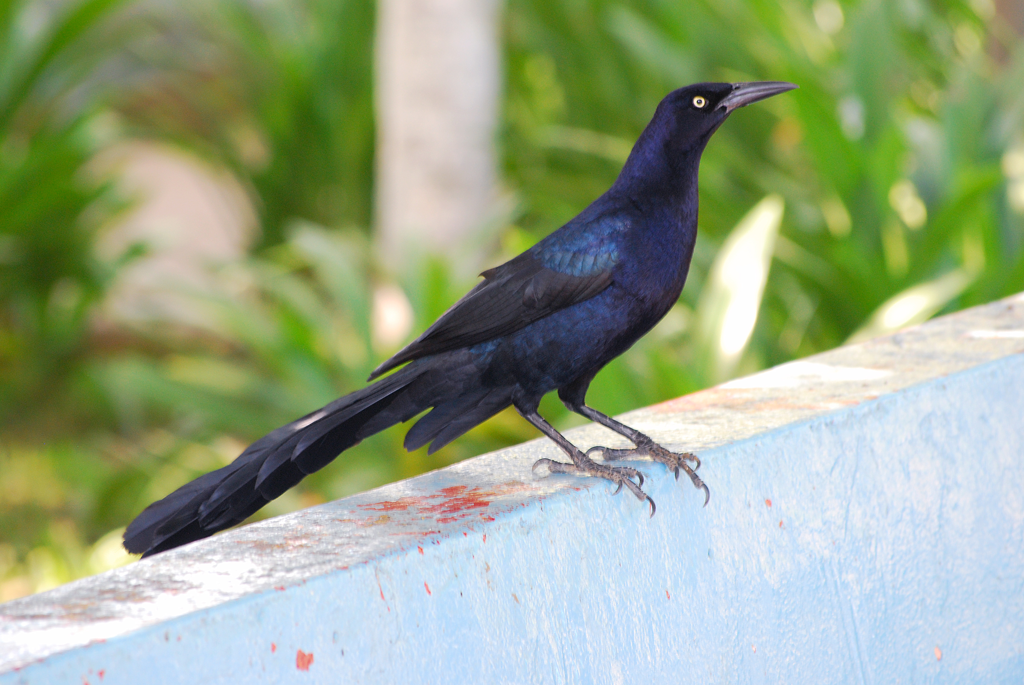

In [9]:

import requests
from io import BytesIO
from PIL import Image
from IPython.display import display
from datasets import load_dataset
from torchvision import transforms

# Grab a single example
pixmo = load_dataset('allenai/pixmo-cap', split='train[:1]')
ex = pixmo[0]
caption = ex['caption'].strip()
image_url = ex['image_url']

# Download and show the image
img = Image.open(BytesIO(requests.get(image_url, timeout=20).content)).convert('RGB')
print('Image URL:', image_url)
print('Caption (ground truth):', caption)
display(img)

# Preprocess for the model
img_size = config.img_size if isinstance(config, TRMVLMConfig) else 224
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image_tensor = transform(img).unsqueeze(0).to(device)

# Tokenize the caption
text = tokenizer(caption, return_tensors='pt', truncation=True, max_length=config.max_seq_len)
input_ids = text['input_ids']
if input_ids.max() >= config.vocab_size or input_ids.min() < 0:
    print(
        f"Warning: tokenizer IDs outside model vocab (min={input_ids.min().item()}, max={input_ids.max().item()}, "
        f"vocab_size={config.vocab_size}). Clipping to avoid CUDA errors."
    )
    input_ids = input_ids.clamp(min=0, max=config.vocab_size - 1)
input_ids = input_ids.to(device)


### Run inference

In [10]:

with torch.no_grad():
    image_emb = model.encode_image(image_tensor)
    text_emb = model.encode_text(input_ids)
    cos_sim = torch.nn.functional.cosine_similarity(image_emb, text_emb).item()

print(f'Image/Text cosine similarity: {cos_sim:.4f}')
print('Image embed shape:', tuple(image_emb.shape))
print('Text embed shape:', tuple(text_emb.shape))


Image/Text cosine similarity: 0.0897
Image embed shape: (1, 128)
Text embed shape: (1, 128)


In [13]:
# Simple text-only query
prompt = "The quick brown fox jumps over"
with torch.no_grad():
    text = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=config.max_seq_len)
    input_ids = text["input_ids"]
    if input_ids.max() >= config.vocab_size or input_ids.min() < 0:
        print(
            f"Warning: tokenizer IDs outside model vocab (min={input_ids.min().item()}, max={input_ids.max().item()}, vocab_size={config.vocab_size}). Clipping to avoid errors."
        )
        input_ids = input_ids.clamp(min=0, max=config.vocab_size - 1)
    input_ids = input_ids.to(device)
    logits = model.language_model(input_ids)["logits"]
    # take the last token distribution and pick top token
    next_id = logits[:, -1].argmax(dim=-1, keepdim=True)
    response_ids = torch.cat([input_ids, next_id], dim=1)
    decoded = tokenizer.batch_decode(response_ids.cpu(), skip_special_tokens=True)[0]
print(decoded)


!!!!!! [unused517]
